## CNN based learning anomaly patterns

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from collections import defaultdict
from multiprocessing import cpu_count

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset

import scipy.stats
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams["font.size"] = 7
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['axes.linewidth'] = 1.0
plt.rcParams['axes.grid'] = True

import warnings
warnings.filterwarnings('ignore')

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
seed = 1
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

In [4]:
import pathlib
from sklearn.preprocessing import minmax_scale

class TSDatasetAnomalyPatterns(Dataset):
    def __init__(self, path: pathlib.Path):
        super(TSDatasetAnomalyPatterns, self).__init__()
        self.df = pd.read_json(str(path), orient='records', lines=True)
        self.time_series = torch.tensor([
            [minmax_scale(li, feature_range=(0, 1)) for li in self.df.loc[:, "time_series"].values]
        ], dtype=torch.float32)  # use float64 to avoid error

        self.joined_categories = self.df.loc[:, ["anomaly_pattern", "anomaly_position"]].apply(
            lambda x: "/".join(x.dropna().astype(str).values), axis=1
        ).to_numpy()

        # string labels to int labels
        self.label_to_category = {i: v for i, v in enumerate(np.unique(self.joined_categories))}
        category_to_label = {v: k for k, v in self.label_to_category.items()}
        self.labels = torch.tensor([
            category_to_label[c] for c in self.joined_categories
        ], dtype=torch.int64)

    def __getitem__(self, idx):
        label = self.labels[idx]
        category = self.label_to_category[label.item()]
        return self.time_series[:, idx], label, category

    def __len__(self):
        return len(self.df)
    
    def number_of_class(self) -> int:
        return len(self.label_to_category.keys())

In [5]:
dataset = TSDatasetAnomalyPatterns(pathlib.Path("../samples/tsdr_anomaly_patterns/labeled_tsdr_anomaly_patterns_20221202-024759.jsonl"))

In [15]:
import torch.utils.data

train_dataset, test_dataset = torch.utils.data.random_split(dataset=dataset, lengths=[0.7, 0.3], generator=torch.Generator().manual_seed(42))
display(len(train_dataset), len(test_dataset))

836

357

In [161]:
# ref. https://github.com/pytorch/examples/blob/f82f5626b6432b8d0b08d58cc91f3bdbb355a772/mnist/main.py

class CNN1d(nn.Module):
    def __init__(self, num_classes: int):
        super(CNN1d, self).__init__()

        self.conv1 = nn.Conv1d(1, 64, kernel_size=4, stride=1)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=4, stride=1)
        self.conv3 = nn.Conv1d(128, 256, kernel_size=4, stride=1)
        # self.dropout1 = nn.Dropout(0.25)
        # self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(43776, 512)  # the number of datapoints in a metric = 60/15 * 45 (45min * 15sec interval)
        self.fc2 = nn.Linear(512, num_classes)  # The number of class is 13 (chaos types) * 2 (anomaly position) + 2 (normal and unknown)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        # x = F.max_pool1d(x, kernel_size=4, stride=1)
        x = self.conv2(x)
        x = F.relu(x)
        # x = F.max_pool1d(x, kernel_size=4, stride=2)
        x = self.conv3(x)
        x = F.relu(x)
        # x = F.max_pool1d(x, kernel_size=4, stride=3)
        # x = self.dropout1(x)
        x = torch.flatten(x, 1)  # Is this necessary?
        x = self.fc1(x)
        x = F.relu(x)
        # x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [150]:
from torchinfo import summary

model = CNN1d(num_classes=dataset.number_of_class()).to(device)
learning_rate = 0.001
epochs = 10
batch_size = 4
test_batch_size = 4
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

summary(model, input_size=(batch_size, 1, 180))

Layer (type:depth-idx)                   Output Shape              Param #
CNN1d                                    [4, 23]                   --
├─Conv1d: 1-1                            [4, 64, 177]              320
├─Conv1d: 1-2                            [4, 128, 171]             32,896
├─Conv1d: 1-3                            [4, 256, 81]              131,328
├─Linear: 1-4                            [4, 512]                  3,408,384
├─Linear: 1-5                            [4, 23]                   11,799
Total params: 3,584,727
Trainable params: 3,584,727
Non-trainable params: 0
Total mult-adds (M): 78.96
Input size (MB): 0.00
Forward/backward pass size (MB): 1.74
Params size (MB): 14.34
Estimated Total Size (MB): 16.09

In [68]:
from dataclasses import dataclass, field

@dataclass
class ScoreHistory:
    train_loss_values: list[float] = field(default_factory=list)
    train_acc_values: list[float] = field(default_factory=list)
    test_loss_values: list[float] = field(default_factory=list)
    test_acc_values: list[float] = field(default_factory=list)
    epochs: int = 0

    def append_train(self, loss: float, acc: float):
        self.train_loss_values.append(loss)
        self.train_acc_values.append(acc)
    
    def append_test(self, loss: float, acc: float):
        self.test_loss_values.append(loss)
        self.test_acc_values.append(acc)
    
    def loss(self, sum_loss, batch_size: int, data_size: int) -> float:
        return sum_loss * batch_size / data_size
    
    def plots(self):
        fig = plt.figure(tight_layout=True, figsize=(15, 5))
        axs = fig.subplots(nrows=1, ncols=2)
        ax_loss, ax_acc = axs[0], axs[1]
        for title, ax, train_values, test_values in zip(("loss", "accuracy"), (ax_loss, ax_acc), (self.train_loss_values, self.train_acc_values), (self.test_loss_values, self.test_acc_values)):
            ax.set_title(title)
            if len(train_values) > 0:
                ax.plot(range(self.epochs), train_values)
            if len(test_values) > 0:
                ax.plot(range(self.epochs), test_values, c='#00ff00')
            ax.set_xlim(0, self.epochs)
            ax.set_ylim(0, max(train_values + test_values) + 0.1)
            ax.set_xlabel("epoch")
            ax.set_ylabel(title)
            ax.legend([f"train {title}", f"test {title}"])
        return fig


def train(model, device, train_loader, optimizer, loss_fn, epoch):
    model.train()
    for data, target, category in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()


def test_train_data(model, device, train_loader, loss_fn, score_history: ScoreHistory):
    model.eval()
    loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for data, target, category in train_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = loss_fn(output, target)
            loss += loss.item()                            #lossを足していく
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)
    
    loss = score_history.loss(loss, len(train_loader.dataset), len(train_loader)) 
    score_history.append_train(
        loss=loss,
        acc=correct / total,
    )

    print('Train set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        loss, correct, len(train_loader.dataset),
        100. * correct / len(train_loader.dataset)))
    

def test(model, device, test_loader, loss_fn, score_history: ScoreHistory):
    model.eval()
    loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for data, target, category in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss += loss_fn(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)

    loss = score_history.loss(loss, len(test_loader.dataset), len(test_loader)) 
    score_history.append_test(
        loss=loss, 
        acc=correct / total,
    )

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

Check overfitting

In [159]:
dataset_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.7)
score_hist = ScoreHistory(epochs=epochs)
for epoch in range(1, epochs + 1):
    train(model, device, dataset_dataloader, optimizer, loss_fn, epoch)
    test(model, device, dataset_dataloader, loss_fn, score_hist)
    scheduler.step()

score_hist.plots()

Test set: Average loss: 470.1857, Accuracy: 1026/1193 (86%)
Test set: Average loss: 466.1110, Accuracy: 1029/1193 (86%)
Test set: Average loss: 463.7025, Accuracy: 1031/1193 (86%)
Test set: Average loss: 462.1067, Accuracy: 1032/1193 (87%)


KeyboardInterrupt: 

Split dataset as train and test set.

Train set: Average loss: 6.7807, Accuracy: 555/836 (66%)
Test set: Average loss: 400.2869, Accuracy: 230/357 (64%)
Train set: Average loss: 30.6399, Accuracy: 686/836 (82%)
Test set: Average loss: 280.0119, Accuracy: 257/357 (72%)
Train set: Average loss: 5.8386, Accuracy: 737/836 (88%)
Test set: Average loss: 266.6027, Accuracy: 254/357 (71%)
Train set: Average loss: 2.9538, Accuracy: 789/836 (94%)
Test set: Average loss: 240.4436, Accuracy: 275/357 (77%)
Train set: Average loss: 1.8527, Accuracy: 816/836 (98%)
Test set: Average loss: 240.4024, Accuracy: 280/357 (78%)
Train set: Average loss: 0.1806, Accuracy: 826/836 (99%)
Test set: Average loss: 258.7754, Accuracy: 284/357 (80%)
Train set: Average loss: 0.6316, Accuracy: 833/836 (100%)
Test set: Average loss: 261.6016, Accuracy: 286/357 (80%)
Train set: Average loss: 0.3202, Accuracy: 832/836 (100%)
Test set: Average loss: 263.8083, Accuracy: 286/357 (80%)


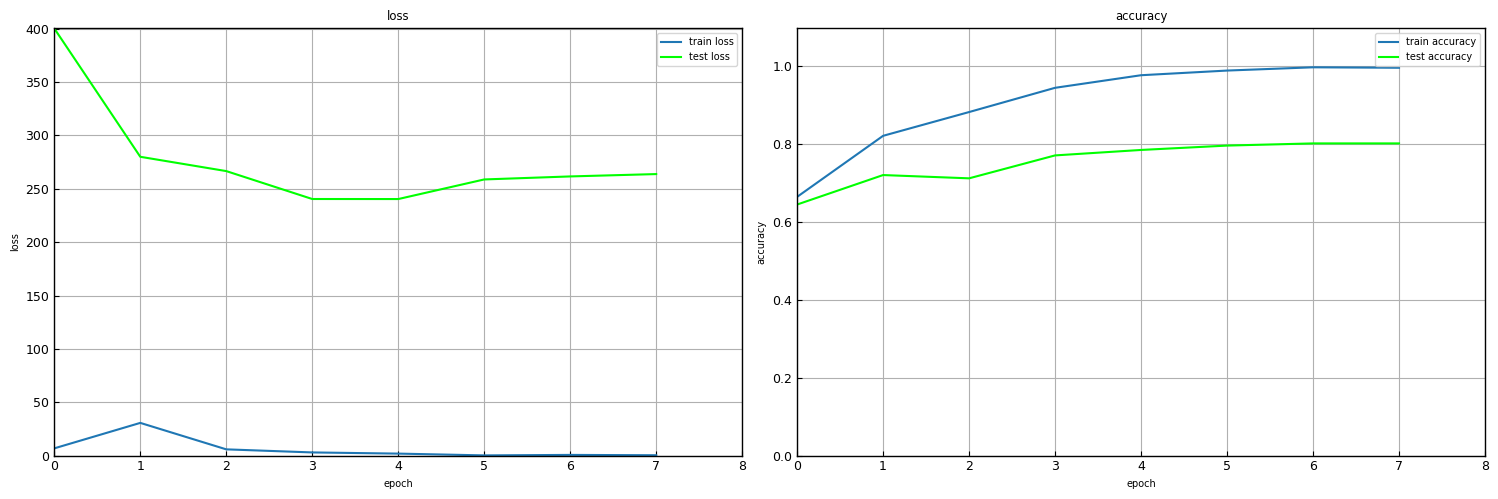

In [162]:
model = CNN1d(num_classes=dataset.number_of_class()).to(device)
learning_rate = 0.001
epochs = 8
batch_size = 8
test_batch_size = 8
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=test_batch_size, shuffle=True, pin_memory=True)

score_hist = ScoreHistory(epochs=epochs)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.7)
for epoch in range(1, epochs + 1):
    train(model, device, train_dataloader, optimizer, loss_fn, epoch)
    test_train_data(model, device, train_dataloader, loss_fn, score_hist)
    test(model, device, test_dataloader, loss_fn, score_hist)
    scheduler.step()

score_hist.plots()
plt.show()